In [1]:
import numpy
numpy.testing.Tester = False
from tamkin import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#sys.path.insert(0, '../code/')
from tamkintools_multi_fidelity_bayesian.tamkin_multi_fidelity import *

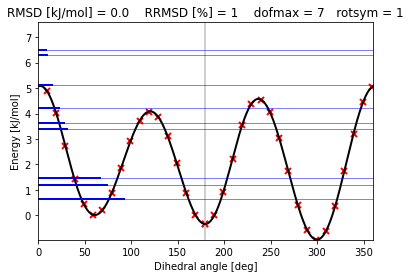

In [2]:
# NpT is used when nothing else is specified (1bar)
monomer = load_molecule_g03fchk("scan_data/ethanolmonomer/mon-p.fchk")
dimer   = load_molecule_g03fchk("scan_data/ethanoldimer/dim-p-p.fchk")
monomer_scan = load_rotscan_g03log("scan_data/ethanolmonomer/mon-p-scan.log")
#monomer_scan = load_rotscan_g03log("mon-np-scan.log")
dimer_scan = load_rotscan_g03log("scan_data/ethanoldimer/dim1-p-p-scan.log", top_indexes= [8])
#dimer_scan = load_rotscan_g03log("dim2-p-p-scan.log")
nma1    = NMA(monomer, ConstrainExt())
nma2    = NMA(dimer, ConstrainExt())
rotor1  = Rotor(monomer_scan, monomer, rotsym=1, even=True, dofmax=7, num_levels = 100)
rotor2  = Rotor(dimer_scan, dimer, rotsym=1, even=False, dofmax=7, num_levels = 100)
pf1rrho = PartFun(nma1, [ExtTrans(), ExtRot(symmetry_number=1)])
pf1     = PartFun(nma1, [ExtTrans(), ExtRot(),rotor1])
pf2rrho = PartFun(nma2, [ExtTrans(), ExtRot(symmetry_number=1)])
pf2     = PartFun(nma2, [ExtTrans(), ExtRot(symmetry_number=1), rotor2])
ta1     = ThermoAnalysis(pf1,     [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta2     = ThermoAnalysis(pf2,     [3, 10, 30, 100, 200, 273.15, 298.15, 310, 400, 500, 1000])
ta2     = ThermoAnalysis(pf2,     [3, 10, 30, 100, 300, 310, 3000])
ta1rrho = ThermoAnalysis(pf1rrho, [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
ta2rrho = ThermoAnalysis(pf2rrho, [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta1.write_to_file("Monomerthermodynamics.csv")
#ta2.write_to_file("Dimerthermodynamics.csv")
#ta1rrho.write_to_file("Monomerthermodynamics_rrho.csv")
#ta2rrho.write_to_file("Dimerthermodynamics_rrho.csv")
#pf1.write_to_file("MonomerPartFun.csv")
#pf2.write_to_file("DimerPartFun.csv")
rotor1.plot_levels("MonomerRotorLevels.png",300)
rotor2.plot_levels("DimerRotorLevels.png",300)




## Two Low Energy Datapoints

This notebook leads to a strategy how to select initial high fidelity sample points

Two data points at the same energy level are not enough for meaningful training, as the relationship between low and high fidelity data cannot be fixed.

An additional data point at a different energy level is necessary for a quantitative description (I think thats actually expected). This also leads to our strategy for selecting the high fidelity points to simulate based on a low fidelity scan:

- global minimum
- global maximum
- local minima (or something else depending on our goal)



# Monomer

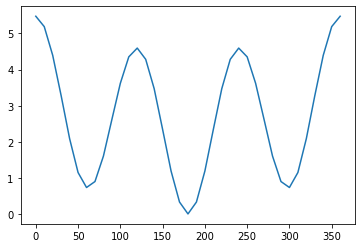

In [3]:
mp2_data = pd.read_csv("scan_data/ethanolmonomer/additional_test.dat",sep=" ")


#mp2_data

cc_dihedral_monomer = np.array( mp2_data["Dihedral[deg]"] )
cc_dihedral_monomer = cc_dihedral_monomer - np.min(cc_dihedral_monomer)
cc_energy_monomer   = -np.array( mp2_data["E[hartree/particle]"] ) #*2625.5002/1000 #/ (1000*2625.5002)
cc_energy_monomer   = cc_energy_monomer - np.min(cc_energy_monomer)
cc_energy_monomer  *= 2625.5002

plt.plot( cc_dihedral_monomer, cc_energy_monomer)

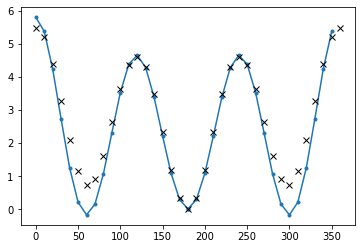

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
angle range: 360.0
set angle range 360.0


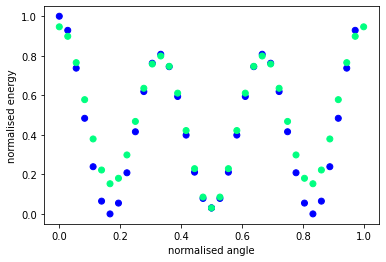

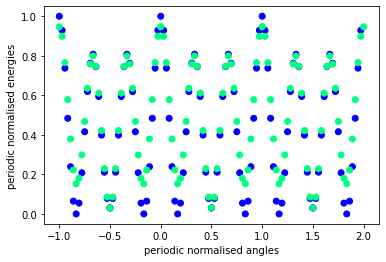

(222, 2)
(222, 1)


reconstraining parameters gp


Optimization restart 1/5, f = -415.0010636565982
Warning - optimization restart 2/5 failed
Warning - optimization restart 3/5 failed
Warning - optimization restart 4/5 failed
Warning - optimization restart 5/5 failed


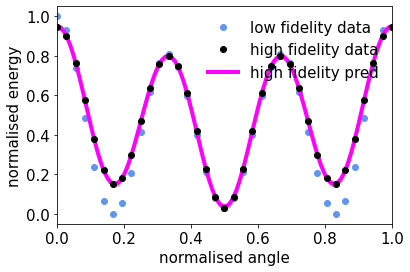

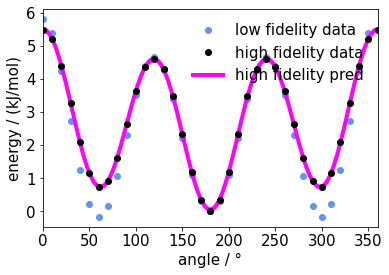

gp.,value,constraints,priors
multifidelity.Mat32.variance,17.09719707470048,+ve,
multifidelity.Mat32.lengthscale,1.0,fixed +ve,
multifidelity.Mat32_1.variance,0.5309099352612556,+ve,
multifidelity.Mat32_1.lengthscale,1.0,fixed +ve,
multifidelity.scale,0.8410986822484454,+ve,
mixed_noise.Gaussian_noise.variance,0.0001,fixed +ve,
mixed_noise.Gaussian_noise_1.variance,0.0001,fixed +ve,


In [4]:

dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# only positive phi vals
tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0001)
tmf.lin_mf_model.gpy_model.kern.Mat32.lengthscale.fix(1)
tmf.lin_mf_model.gpy_model.kern.Mat32_1.lengthscale.fix(1)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("add_normalised_multi_fidelity_all_data")
tmf.plot_results("add_multi_fidelity_all_data")

tmf.lin_mf_model.gpy_model



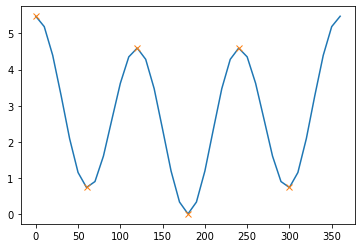

In [5]:
x = np.sort( np.array( [60, 120, 180, 240, 300, 0] ) )

indices = np.where(np.in1d( cc_dihedral_monomer, x))
y = cc_energy_monomer[indices]

plt.plot( cc_dihedral_monomer, cc_energy_monomer )
plt.plot( x,y,"x" )


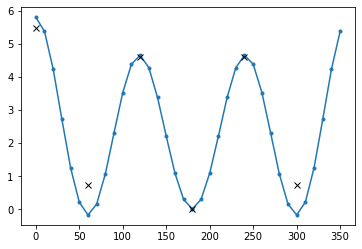

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
angle range: 350.0000070029288
set angle range 360.0


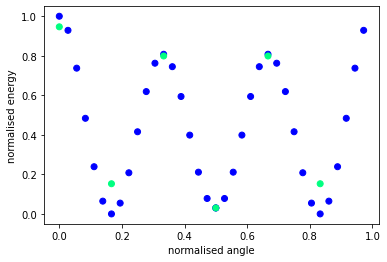

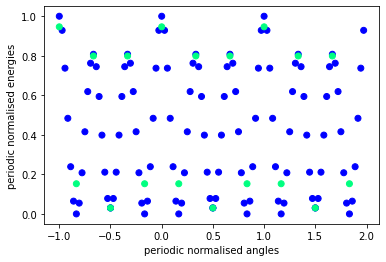

(129, 2)
(129, 1)
Optimization restart 1/5, f = -156.7853218538665
Warning - optimization restart 2/5 failed
Warning - optimization restart 3/5 failed
Warning - optimization restart 4/5 failed
Warning - optimization restart 5/5 failed


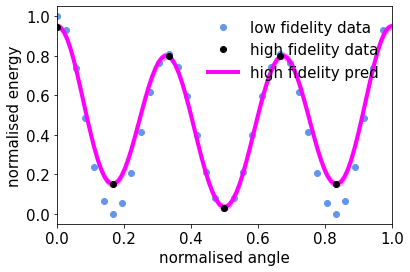

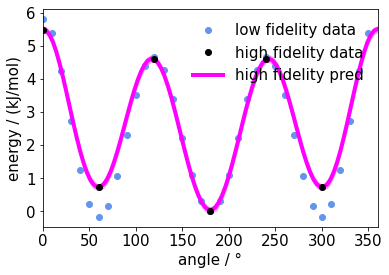

gp.,value,constraints,priors
multifidelity.Mat32.variance,17.808157467987645,+ve,
multifidelity.Mat32.lengthscale,1.0,+ve fixed,
multifidelity.Mat32_1.variance,0.24123993251771705,+ve,
multifidelity.Mat32_1.lengthscale,1.0,+ve fixed,
multifidelity.scale,0.8585877361262895,,
mixed_noise.Gaussian_noise.variance,0.0001,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,0.0001,+ve fixed,


In [6]:
cc_dihedral_monomer = x 
cc_energy_monomer   = y 


dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# only positive phi vals
#tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0001)
tmf.lin_mf_model.gpy_model.kern.Mat32.lengthscale.fix(1)
tmf.lin_mf_model.gpy_model.kern.Mat32_1.lengthscale.fix(1)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("add_normalised_multi_fidelity_0")
tmf.plot_results("add_multi_fidelity_0")

tmf.lin_mf_model.gpy_model


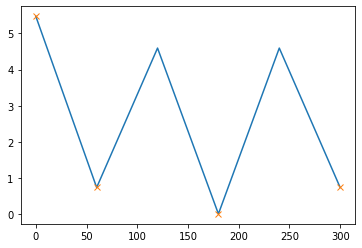

In [7]:
x = np.sort( np.array( [60, 180 , 300, 0] ) )

indices = np.where(np.in1d( cc_dihedral_monomer, x))
y = cc_energy_monomer[indices]

plt.plot( cc_dihedral_monomer, cc_energy_monomer )
plt.plot( x,y,"x" )

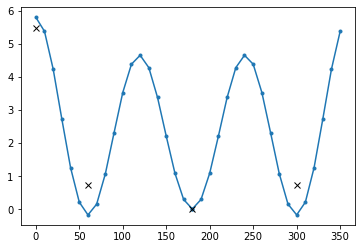

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
angle range: 350.0000070029288
set angle range 360.0


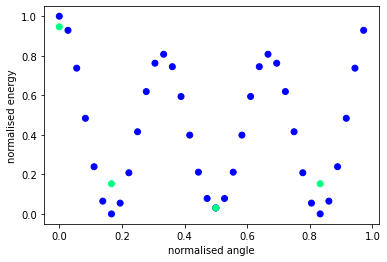

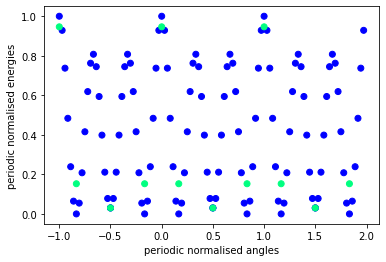

(123, 2)
(123, 1)
Optimization restart 1/5, f = -152.4835808995779
Warning - optimization restart 2/5 failed
Warning - optimization restart 3/5 failed
Warning - optimization restart 4/5 failed
Warning - optimization restart 5/5 failed


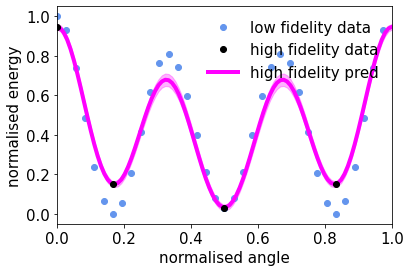

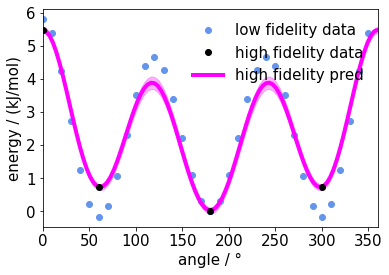

gp.,value,constraints,priors
multifidelity.Mat32.variance,17.803245316540405,+ve,
multifidelity.Mat32.lengthscale,1.0,+ve fixed,
multifidelity.Mat32_1.variance,0.09642050653965462,+ve,
multifidelity.Mat32_1.lengthscale,1.0,+ve fixed,
multifidelity.scale,0.7597699142516691,,
mixed_noise.Gaussian_noise.variance,0.0001,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,0.0001,+ve fixed,


In [8]:
cc_dihedral_monomer = x 
cc_energy_monomer   = y 


dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# only positive phi vals
#tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0001)
tmf.lin_mf_model.gpy_model.kern.Mat32.lengthscale.fix(1)
tmf.lin_mf_model.gpy_model.kern.Mat32_1.lengthscale.fix(1)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("add_normalised_multi_fidelity_1")
tmf.plot_results("add_multi_fidelity_1")

tmf.lin_mf_model.gpy_model